In [1]:
! pip install preprocessor
! pip install sentencepiece
! wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

  Created wheel for preprocessor: filename=preprocessor-1.1.3-cp36-none-any.whl size=4478 sha256=7a930e6c1088ff353ed6ec2c2019e4ea131e9328607ecfdb25f01197bc6e5e70
  Stored in directory: /root/.cache/pip/wheels/98/c1/a2/21fbcfd80d76576bbf148991a66f00730f541f265c7600000f
Successfully built preprocessor
     |████████████████████████████████| 1.2MB 8.4MB/s 


In [2]:
import re    # for regular expressions 
import nltk   # for text manipulation 
import string # for text manipulation 
import warnings 
import numpy as np 
import pandas as pd # for data manipulation 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


#import twint

import preprocessor as p

from collections import Counter
from wordcloud import WordCloud


import spacy 
import en_core_web_sm

from sklearn import feature_extraction, model_selection, manifold, preprocessing, feature_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from keras.layers import Reshape, Embedding, Conv1D, MaxPooling1D,GlobalMaxPooling1D, Flatten, Dense,LSTM, GRU,Bidirectional,Dropout, Conv3D
from tensorflow.keras import Input
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow import keras
import keras.backend as K
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf

from gensim.models import KeyedVectors

import os




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
 def get_dataset_depressed():
  data_normal_tweet = pd.read_csv("./drive/MyDrive/MLproject/training.1600000.processed.noemoticon.csv",encoding='latin-1')

  DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
  data_normal_tweet.columns = DATASET_COLUMNS
  data_normal_tweet.drop(['date','flag','user',"target"], axis = 1,inplace = True)
  data_normal_tweet['depression'] = 0
  data_normal_tweet.head()
  data_normal_tweet = data_normal_tweet.copy().sample(20000, random_state=42)
  #print(data_normal_tweet)

  col_names = ['ids', 'text']
  data_depressed_tweet = pd.read_csv("./drive/MyDrive/MLproject/depressive_tweets_processed.csv",encoding='latin-1', sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names)
  data_depressed_tweet['depression'] = 1
  data_depressed_tweet.head()
  data_depressed_tweet.shape

  dataset = pd.concat([data_depressed_tweet,data_normal_tweet])
  dataset['text'] = dataset['text'].apply(str)

  return dataset


In [6]:
def get_dataset():
  dataset = pd.read_csv("./drive/MyDrive/MLproject/training.1600000.processed.noemoticon.csv",encoding='latin-1')

  DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
  dataset.columns = DATASET_COLUMNS
  dataset.drop(['date','flag','user'],axis = 1,inplace = True)
  dataset["target"] = dataset.target.replace(4,1)

  #data_normal_tweet['depression'] = 0
  dataset = dataset.copy().sample(50000, random_state=42)
  #data_normal_tweet = dataset.iloc[-200000:, :]
  #data_depressed_tweet = dataset.iloc[200000: , :]
  #dataset = pd.concat([data_depressed_tweet,data_normal_tweet])


  return dataset


# Preprocessing

In [7]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def process_text(text, hashtags, mentions, urls):
  text = hashtags.sub(' hashtag', text)
  text = mentions.sub(' entity', text)
  text = urls.sub('urls', text)
  return text.strip().lower()





In [8]:
def clean_text(dataset):
  dataset['text'] = dataset['text'].apply(lambda x : remove_URL(x))
  dataset['text'] = dataset['text'].apply(lambda x : remove_html(x))
  dataset['text'] = dataset['text'].apply(lambda x : remove_emoji(x))
  hashtags = re.compile(r"^#\S+|\s#\S+")
  mentions = re.compile(r"^@\S+|\s@\S+")
  urls = re.compile(r"https?://\S+")
  
  dataset['cleaned_text'] = dataset.text.apply(lambda x : process_text(x, hashtags, mentions, urls))
  dataset['cleaned_text'] = execute_nlp(dataset)
  
  return dataset



In [9]:
def execute_nlp(dataset):
  nlp = spacy.load('en')  
  dataset['cleaned_text'] = dataset['text'].apply(lambda x: [t.lemma_.lower() for t in nlp.tokenizer(x) if ((not t.is_stop) and ( not t.is_punct) and (not t.is_currency) and (not t.is_digit) and (not t.is_space) and (t.is_alpha)) ])
 # dataset['sentiment'] = dataset['stars'].apply(lambda x: 0 if x < 3 else 1)
  #adding label for sentiment class
 # dataset.to_csv('./drive/My Drive/Artificial_intelligent_project/subset_review_spacy.csv', sep='\t')
  return dataset['cleaned_text']


In [10]:
def get_wordclouds(dataset):
  depressive_tweets = dataset.loc[dataset['target'] == 0]
  normal_tweets = dataset.loc[dataset['target'] == 1]
  print("depressive ",depressive_tweets)
  print("normal ", normal_tweets)
  #depressive_tweets = [clean_tweets([t for t in data_depressed_tweet['text']])]
  depressive_words = ' '.join(list(map(str, depressive_tweets['cleaned_text'])))
  depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)

  #depressive_tweets = [clean_tweets([t for t in data_normal_tweet['text']])]
  normal_words = ' '.join(list(map(str, normal_tweets['cleaned_text'])))
  normal_wc = WordCloud(width = 512,height = 512, colormap="hsv", background_color="white").generate(normal_words)
  
  #plt.subplot(211)
  plt.figure(figsize = (10, 8), facecolor = 'k')
  plt.imshow(depressive_wc)
  plt.axis('off')
  plt.tight_layout(pad = 0)
  
  #plt.subplot(212)
  plt.figure(figsize = (10, 8))
  plt.imshow(normal_wc)
  plt.axis('off')
  plt.tight_layout(pad = 0)

  plt.show()


In [11]:
def split_dataset(X, y):
  #X = df.iloc[:, 0 ]
  # y = df.iloc[:, 4 ]
  X_train, X_test, y_train, y_test= model_selection.train_test_split(X, y, test_size=0.25, random_state = 42, shuffle = True)
  X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.15, random_state = 42, shuffle = True)

  return X_train, X_test, y_train, y_test, X_val, y_val

def multinomialNBmodel():
  nb = Pipeline([('vectorizer', feature_extraction.text.CountVectorizer()),
                ('tfidf', feature_extraction.text.TfidfTransformer()),
               ('clf', MultinomialNB()),])
  return nb 

def logisticRegressionModel():
  logRegression =  Pipeline([('vectorizer', feature_extraction.text.CountVectorizer()),
                #('tfidf', feature_extraction.text.TfidfTransformer()),
               ('clf', LogisticRegression()),])
  return logRegression 

def SVMmodel():
  svm = Pipeline([('vectorizer', feature_extraction.text.CountVectorizer()),
               #('tfidf', feature_extraction.text.TfidfTransformer()),
               ('clf',  SGDClassifier(penalty='l2', alpha=1e-3, random_state=42)),])
  return svm

def getPerformanceMetrics(model, X_test, y_test, modelName):
  from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,roc_curve,auc,precision_recall_curve
  y_pred = model.predict(X_test)
  if not modelName == "multinomialNBmodel":
    y_pred = y_pred.round()
  
  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred, target_names=["normal", "depressed" ]))
   ## Plot confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=["normal", "depressed" ], 
        yticklabels=["normal", "depressed" ], title="Confusion matrix" + modelName)
  plt.yticks(rotation=0)

def compute_baseline( X_train, X_test, y_train, y_test, X_val, y_val):   #model = multinomialNBmodel()
  #X_train, X_test, y_train, y_test, X_val, y_val = split_dataset(df.iloc[:, 3 ], df.iloc[:, 2])  #cleaned text and string label
  model = multinomialNBmodel()
  model.fit(X_train, y_train)
  getPerformanceMetrics(model, X_test, y_test, "multinomialNBmodel" )
  return model


## Word Embedding 

In [12]:
import requests, zipfile, io
def glove_download(): 
  if  not os.path.isfile('./drive/MyDrive/glove.840B.300d.txt/glove.840B.300d.txt'):
    print("Downloading... ")
    zip_file_url = "http://nlp.stanford.edu/data/glove.840B.300d.zip"
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("./drive/MyDrive/glove.840B.300d.txt")
  else: 
    print("glove has already been downloaded")



In [13]:
def inits_params_word_embedding(vocab_len, max_sequence_length, embedding_dim ):
  MAX_NB_WORDS = vocab_len
  MAX_SEQUENCE_LENGTH = 32 # 800
  #VALIDATION_SPLIT = val_split  #0.2
  EMBEDDING_DIM = embedding_dim #300 #has to be between 100 and 300
  
  return MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM


In [14]:
def glove_encode_text(MAX_NB_WORDS,  MAX_SEQUENCE_LENGTH, text, tokenizer):
  #print(text)
  #convert data into vector to fit word embedding:
    # it means vectorize a text corpus, by turning each text into either a sequence of integers 
  tokenizer.fit_on_texts(text)   #In the case where texts contains lists, we assume each entry of the lists to be a token.

  text_sequences = tokenizer.texts_to_sequences(text)  #turn each list into a "sequence": is a list of integer word indices. 
  print(text_sequences)
  text_sequences = pad_sequences(text_sequences, maxlen = MAX_SEQUENCE_LENGTH) #X
  

  return text_sequences


In [15]:
def data_preparation(MAX_NB_WORDS,  MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, X_train, X_test, X_val):
  #convert data into vector to fit word embedding:
    # it means vectorize a text corpus, by turning each text into either a sequence of integers 
  #print(X_train.head(5))
  tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
  tokenizer.fit_on_texts(X_train)   #In the case where texts contains lists, we assume each entry of the lists to be a token.
  tokenizer.fit_on_texts(X_test)
  tokenizer.fit_on_texts(X_val)

  X_train_sequences = tokenizer.texts_to_sequences(X_train)  #turn each list into a "sequence": is a list of integer word indices. 
  X_test_sequences = tokenizer.texts_to_sequences(X_test) 
  X_val_sequences = tokenizer.texts_to_sequences(X_val) 
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  #print(X_train_sequences)

  X_train_sequences = pad_sequences(X_train_sequences, maxlen = MAX_SEQUENCE_LENGTH) #X
  X_test_sequences = pad_sequences(X_test_sequences, maxlen = MAX_SEQUENCE_LENGTH) #X
  X_val_sequences = pad_sequences(X_val_sequences, maxlen = MAX_SEQUENCE_LENGTH) #X

  return word_index, X_train_sequences, X_test_sequences, X_val_sequences, tokenizer


In [16]:
def load_word_embedding(filename):
  #extracting vocabs from 'word_embedding.txt'
  embeddings_index = {}
  f = open(os.path.join("", filename),encoding='utf-8' )
  for line in tqdm(f):
      values = line.rstrip().rsplit(' ')
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  print('Found %s word vectors.' % len(embeddings_index))

  return embeddings_index

In [17]:
#create embedding matrix that join pretrained word embedding with the dataset's vocabulary
def create_embedding_matrix(embeddings_index, word_index, EMBEDDING_DIM):
  embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
  return embedding_matrix


In [18]:
def inits_params_embedding_layer(embedding_matrix, word_index, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM):
  print("embedding_layer")
  embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
  return embedding_layer

In [19]:
def plot_accuracy_loss(history): 
  plt.subplot(211)
  plt.plot(history.history['get_f1'])
  plt.title('model f1_score')
  plt.ylabel('f1_score')
  plt.plot(history.history['val_get_f1'])
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.subplot(212)
  plt.plot(history.history['loss'])
  plt.title('val loss')
  plt.ylabel('loss')
  plt.plot(history.history['val_loss'])
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [20]:
def run_model(model,  x_train, y_train,  x_val, y_val, modelName):
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=[get_f1, "accuracy"])
  es_callback = EarlyStopping(monitor='val_loss', patience=3)
  #history = model.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_val, y_val), callbacks=[es_callback], shuffle=False)
  model.summary()
  # happy learning!
  history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
            epochs=20, batch_size=64,  callbacks=[es_callback], shuffle=False)
  model.save(modelName)
  
  plot_accuracy_loss(history)

  print("history", history)
  hist_df = pd.DataFrame(history.history) 

  hist_csv_file = './drive/MyDrive/MLproject/history/history' + modelName.replace("./drive/MyDrive/MLproject/", "") + '.csv'   
  with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
  return model

In [21]:

def define_CNN_model(embedding_layer, MAX_SEQUENCE_LENGTH):

  sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedded_sequences = embedding_layer(sequence_input)
  x = Conv1D(64, 5, activation='relu')(embedded_sequences)
  x = MaxPooling1D()(x)  # global max pooling
  x = Conv1D(64, 5, activation='relu')(x)
  x = MaxPooling1D()(x)  # global max pooling
  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.2)(x)
  preds = Dense(1, activation='sigmoid')(x)
  model = keras.Model(sequence_input, preds) 

  """sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedded_sequences = embedding_layer(sequence_input)
  x = Dropout(0.2)(embedded_sequences)
  x = Conv1D(64, 5, activation='relu')(embedded_sequences)
  x = MaxPooling1D(pool_size=4)(x)
  x = LSTM(64) (x)
  preds = Dense(1, activation='sigmoid')(x)
  model = keras.Model(sequence_input, preds)"""

  
  return model


In [22]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [23]:
def compute_word_embedding_model(df, X_train, X_test, y_train, y_test, X_val, y_val): 
  glove_download()
  embeddings_index = load_word_embedding('./drive/MyDrive/glove.840B.300d.txt/glove.6B.100d.txt')
  #TODO: define MAX_NB_WORDS correctly
  #dataset.insert(1, 'number_of_words', dataset.cleaned_text.apply(lambda x: len(x)))
  max_words_for_sentence = dataset["number_of_words"].max()

  max_words_for_sentence = dataset["number_of_words"].max()
  median_words_for_sentence = dataset["number_of_words"].median()

  MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM = inits_params_word_embedding(len(embeddings_index), max_words_for_sentence, 100 )
  word_index, x_train, x_test, x_val, tokenizer = data_preparation(MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, X_train, X_test, X_val)
  
  embedding_matrix =create_embedding_matrix(embeddings_index, word_index, EMBEDDING_DIM)

  if not os.path.isdir("./drive/MyDrive/MLproject/CNN_model_glove_WE2"):
    print("models are training...")
    embedding_layer = inits_params_embedding_layer(embedding_matrix, word_index, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM )
    CNN_model_glove_we = define_CNN_model(embedding_layer, MAX_SEQUENCE_LENGTH) 
    CNN_model_glove_we = run_model(CNN_model_glove_we, x_train, y_train,  x_val, y_val, "./drive/MyDrive/MLproject/CNN_model_glove_WE2")
    getPerformanceMetrics(CNN_model_glove_we, x_test, y_test, "./drive/MyDrive/MLproject/CNN_model_glove_WE2" )
  else: 
    #load trained models
    print("models already trained, loading...")
    CNN_model_glove_we = tf.keras.models.load_model('./drive/MyDrive/MLproject/CNN_model_glove_WE2',  custom_objects={'get_f1': get_f1}) 
    getPerformanceMetrics(CNN_model_glove_we, x_test, y_test, "./drive/MyDrive/MLproject/CNN_model_glove_WE2" )
  print("finito")
  return CNN_model_glove_we, MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, tokenizer

### Word2Vec

In [24]:
def create_custom_word_embedding(df):
    sentences = [row.split() for row in df['cleaned_text']] #tokenize sentence
    w2v_model = Word2Vec(min_count=100, #min_count: minimum amount of time a word appear in word2vec training corpus  
                        window=5,  # context window +- center word
                        size=100,  # dimensions of word embeddings, also refer to size of hidden layer
                        workers=4,
                        sg =1 )#1= skip-gram, 0 = cbow
                        
    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
    w2v_model.init_sims(replace=True)
    print("vocab length",len(w2v_model.wv.vocab))
    return  w2v_model


In [25]:
#testing word embedding
#Find the most similar words for "smoke"
def test_word_embedding(w2v_model, word):
  print(w2v_model.wv.most_similar(positive=[word]))



In [26]:
from sklearn.manifold import TSNE
def visualize_word2vec_model(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


In [27]:
def save_pretrained_word_embedding(filename, isBin, w2v_model):
  w2v_model.wv.save_word2vec_format(filename, binary = isBin)


In [28]:
from gensim.models import Word2Vec, KeyedVectors
from collections import defaultdict
def training_over_custom_word_embedding(df, X_train, X_test, y_train, y_test, X_val, y_val):
  w2v_model = create_custom_word_embedding(df)  
  #visualize_word2vec_model(w2v_model)
  save_pretrained_word_embedding("./drive/MyDrive/MLproject/word_embedding.txt", False, w2v_model)
  w2v_model = KeyedVectors.load_word2vec_format('./drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)
  #get dataset info
  #dataset.insert(1, 'number_of_words', dataset.cleaned_text.apply(lambda x: len(x)))

  max_words_for_sentence = df["number_of_words"].max()
  median_words_for_sentence = df["number_of_words"].median()
  vocab_len = len(w2v_model.wv.vocab)
  print("vocab length: ",len(w2v_model.wv.vocab), "max", max_words_for_sentence)



  MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM = inits_params_word_embedding(len(w2v_model.wv.vocab), max_words_for_sentence, 100 )
  word_index, x_train, x_test, x_val, tokenizer = data_preparation(MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, X_train, X_test, X_val)

  embeddings_index = load_word_embedding('./drive/MyDrive/GoogleNews-vectors-negative300.bin')
  embedding_matrix = create_embedding_matrix(embeddings_index, word_index, EMBEDDING_DIM)
  if not os.path.isdir("./drive/MyDrive/MLproject/CNN_model_custom_WEskipgram") :
    print("models are training...")
    embedding_layer = inits_params_embedding_layer(embedding_matrix, word_index, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM )
    CNN_model_custom_we = define_CNN_model(embedding_layer, MAX_SEQUENCE_LENGTH) 
    CNN_model_custom_we = run_model(CNN_model_custom_we, x_train, y_train,  x_val, y_val, "./drive/MyDrive/MLproject/CNN_model_custom_WEskipgram")
    getPerformanceMetrics(CNN_model_custom_we, x_test, y_test,"./drive/MyDrive/MLproject/CNN_model_custom_WEskipgram" )
  else:
    #load trained models
    print("models already trained, loading...")
    CNN_model_custom_we = tf.keras.models.load_model('./drive/MyDrive/MLproject/CNN_model_custom_WEskipgram',  custom_objects={'get_f1': get_f1}) 
  
  return CNN_model_glove_we, MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, tokenizer

#### Bert 

In [29]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization

In [30]:
### Add tokens to the data make it BERT compatible
def bert_encode(test_df, tokenizer, max_len=512):
  
    all_tokens = []
    all_masks = []
    all_segments = []
    
    #for text in texts:
    for i in tqdm(range(len(test_df))):
        text = tokenizer.tokenize(test_df.iloc[i])
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    flat_layer = Flatten()(clf_output)
    dropout= Dropout(0.2)(flat_layer)

    out = Dense(1, activation='sigmoid')(dropout)
   
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy', get_f1])

    return model

In [31]:
def training_with_bert(X_train, X_test, y_train, y_test, X_val, y_val, modelName):
  
  #split dataset
  #X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state = 42)
  #X_train, X_test, y_train, y_test, X_val, y_val = split_dataset(X, y)

  module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"

  bert_layer = hub.KerasLayer(module_url, trainable=True)

  vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
  do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

  tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
  train_input = bert_encode(X_train, tokenizer, max_len=128)
  test_input = bert_encode(X_test, tokenizer, max_len=128)
  val_input = bert_encode(X_val, tokenizer,  max_len=128)

  if not os.path.isdir(modelName):
    print("models are training...")
    bert = build_model(bert_layer, max_len=128)
    bert.summary()
    es_callback = EarlyStopping(monitor='val_loss', patience=3)
    history = bert.fit(
          train_input, y_train,
          validation_data = (val_input, y_val), 
          epochs=3,
          batch_size=8,
          callbacks=[es_callback]
    )
    #bert = run_model(bert, train_input, y_train,  x_val, y_val, "./drive/MyDrive/MLproject/bert_model")
    bert.save(modelName)
    getPerformanceMetrics(bert, test_input, y_test, modelName )
  else: 
    #load trained models
    print("models already trained, loading...")
    bert = tf.keras.models.load_model(modelName,  custom_objects={'get_f1': get_f1}) 
    getPerformanceMetrics(bert, test_input, y_test, modelName )

  return bert, tokenizer

In [32]:
#embeddings_index = load_word_embedding('./drive/MyDrive/glove.840B.300d.txt/glove.840B.300d.txt')


In [33]:
#dataset = get_dataset_depressed()
dataset = get_dataset()
dataset = clean_text(dataset)
dataset.insert(1, 'number_of_words', dataset.cleaned_text.apply(lambda x: len(x)))
dataset['cleaned_text'] = dataset['cleaned_text'].apply(lambda x: ', '.join(map(str, x)))
dataset = dataset.dropna()
dataset[dataset.isna().any(axis=1)]
dataset.to_csv("./drive/MyDrive/MLproject/preprocessed_dataset.csv")

In [34]:
dataset = pd.read_csv("./drive/MyDrive/MLproject/preprocessed_dataset.csv",encoding='latin-1')

In [35]:
dataset = dataset.drop("Unnamed: 0", axis = 1)


In [36]:
#dataset['cleaned_text'] = dataset['cleaned_text'].apply(lambda x: ', '.join(map(str, x)))
dataset = dataset.dropna()
dataset[dataset.isna().any(axis=1)]


,target,number_of_words,ids,text,cleaned_text


       target  ...                                       cleaned_text
0           0  ...  poor, little, dumpling, holmdel, vids, try, ho...
1           0  ...  bed, get, to, wake, hella, early, tomorrow, mo...
2           0  ...                   not, able, listen, speaker, bust
3           0  ...  remember, solve, relatively, big, equation, un...
4           0  ...                                    ate, feel, sick
...       ...  ...                                                ...
49995       0  ...        wanna, eat, ham, sandwhich, not, think, bad
49996       0  ...  ok, guess, stop, bsing, highway, winston, sale...
49997       0  ...  plan, month, apparently, take, break, maybe, a...
49998       0  ...                                work, till, tonight
49999       0  ...                           fkkk, nurse, cough, lung

[49577 rows x 5 columns]
depressive         target  ...                                       cleaned_text
0           0  ...  poor, little, dumpling, holmdel,

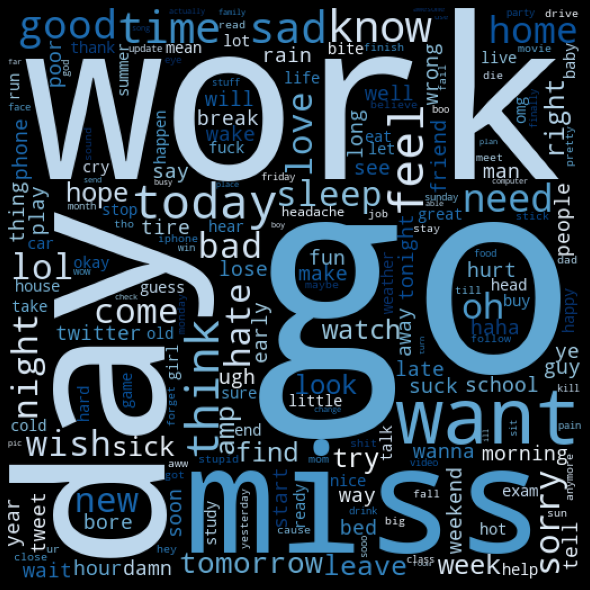

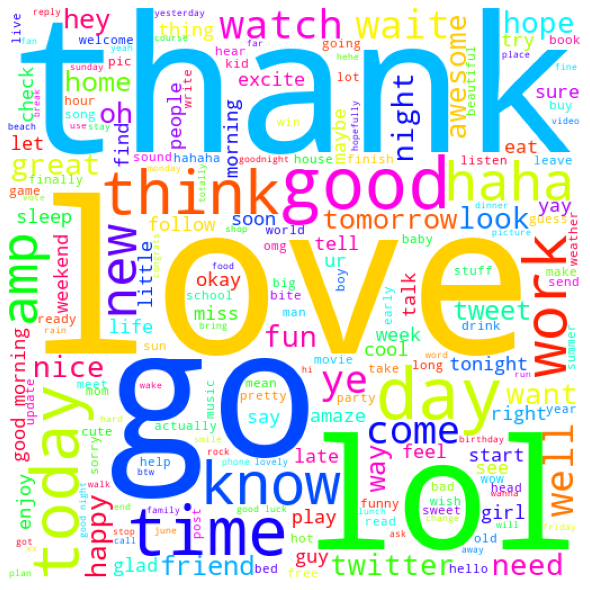

0it [00:00, ?it/s]

accuracy 0.7338442920532473
              precision    recall  f1-score   support

      normal       0.73      0.75      0.74      6224
   depressed       0.74      0.72      0.73      6171

    accuracy                           0.73     12395
   macro avg       0.73      0.73      0.73     12395
weighted avg       0.73      0.73      0.73     12395

glove has already been downloaded


400000it [00:11, 35457.08it/s]


Found 400000 word vectors.
Found 30001 unique tokens.
models already trained, loading...
accuracy 0.6473578055667608
              precision    recall  f1-score   support

      normal       0.66      0.61      0.64      6224
   depressed       0.64      0.68      0.66      6171

    accuracy                           0.65     12395
   macro avg       0.65      0.65      0.65     12395
weighted avg       0.65      0.65      0.65     12395

finito


100%|██████████| 5578/5578 [00:00<00:00, 7526.72it/s]


models already trained, loading...
accuracy 0.8405002016942316
              precision    recall  f1-score   support

      normal       0.84      0.85      0.84      6224
   depressed       0.84      0.83      0.84      6171

    accuracy                           0.84     12395
   macro avg       0.84      0.84      0.84     12395
weighted avg       0.84      0.84      0.84     12395



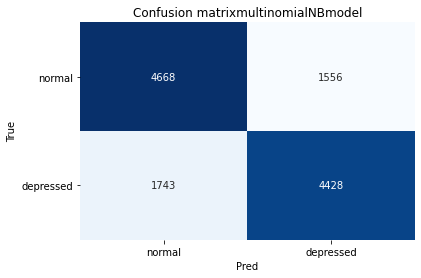

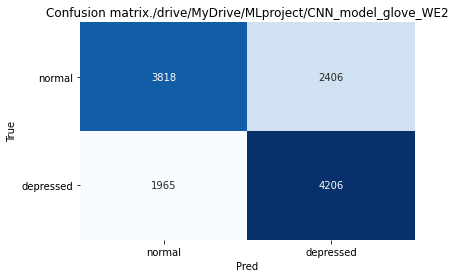

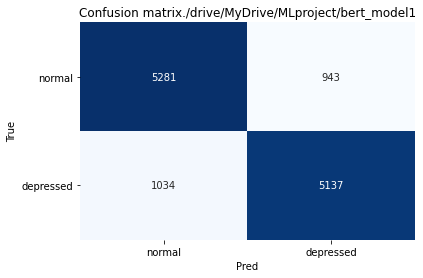

In [37]:
#dataset = get_dataset()
#dataset = clean_text(dataset)
#dataset['cleaned_text'] = execute_nlp(dataset)
print(dataset)
#dataset.to_csv("./drive/MyDrive/MLproject/preprocessed_dataset")
get_wordclouds(dataset)

#dataset['cleaned_text'] = dataset['cleaned_text'].apply(lambda x: ', '.join(map(str, x)))
#print(dataset)

dataset = shuffle(dataset)

X_train, X_test, y_train, y_test, X_val, y_val = split_dataset(dataset["cleaned_text"], dataset["target"])

baseline_model = compute_baseline(X_train, X_test, y_train, y_test, X_val, y_val)

CNN_model_glove_we, MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, tokenizer = compute_word_embedding_model(dataset, X_train, X_test, y_train, y_test, X_val, y_val)
#CNN_model_word2vec_we, MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, tokenizer = training_over_custom_word_embedding(dataset, X_train, X_test, y_train, y_test, X_val, y_val)

bert_model, tokenizerBert = training_with_bert(X_train, X_test, y_train, y_test, X_val, y_val, "./drive/MyDrive/MLproject/bert_model1")


In [39]:
text = pd.DataFrame([["I'm proud of the good job we have done today"],["Today my little baby started crawling for the first time"],["I'm going through the worst time of my life"],["Today I won the lottery prize at the office"],["I want to die"],[ "I feel like my emotions have been amplified lately and it's just made my depression and anxiety so much worse. It's like a state of self loathing and I don't even blame people for not wanting to be around me anymore.You aren't alone and I'm glad you're speaking up"]], columns = ['Name'])
nlp = spacy.load('en')  
text["cleaned_text"] = text["Name"].apply(lambda x: [t.lemma_.lower() for t in nlp.tokenizer(x) if ((not t.is_stop) & ( not t.is_punct) & (not t.is_currency) & (not t.is_digit) & (not t.is_space) & (t.is_alpha)) ])
glove_encoded_text = glove_encode_text(MAX_NB_WORDS,  MAX_SEQUENCE_LENGTH, text["cleaned_text"] , tokenizer)
prediction_glove = CNN_model_glove_we.predict(glove_encoded_text)

text["cleaned_text"]  = text["cleaned_text"] .apply(lambda x: ', '.join(map(str, x)))
bert_encoded_text = bert_encode(text["cleaned_text"], tokenizerBert, max_len=128)
prediction_bert = bert_model.predict(bert_encoded_text)
text["Glove prediction"] = prediction_glove >0.5
text["BERT prediction"] = prediction_bert > 0.5

text["Glove prediction"] = text["Glove prediction"].apply(lambda x: "Negative sentiment" if not x else "Positive sentiment")
text["BERT prediction"] = text["Glove prediction"].apply(lambda x: "Negative sentiment" if not x else "Positive sentiment")

text


100%|██████████| 6/6 [00:00<00:00, 1839.20it/s]

[[621, 3, 184, 8], [8, 81, 136, 58, 2879, 9], [1, 128, 9, 88], [8, 139, 3716, 2836, 309], [15, 267], [18, 6, 3197, 11932, 782, 4190, 3377, 128, 6, 764, 740, 8256, 1333, 60, 15, 245, 152, 522]]


,Name,cleaned_text,Glove prediction,BERT prediction
0,I'm proud of the good job we have done today,"proud, good, job, today",Positive sentiment,True
1,Today my little baby started crawling for the ...,"today, little, baby, start, crawl, time",Positive sentiment,False
2,I'm going through the worst time of my life,"go, wrong, time, life",Positive sentiment,False
3,Today I won the lottery prize at the office,"today, win, lottery, prize, office",Negative sentiment,True
4,I want to die,"want, die",Negative sentiment,False
5,I feel like my emotions have been amplified la...,"feel, like, emotion, amplify, lately, depressi...",Negative sentiment,False


In [40]:
def insert_tweet():
  sentence = input('Insert the sentence to classify: ')
  x = pd.DataFrame([sentence], columns = ['text'])
  nlp = spacy.load('en')  
  x = x['text'].apply(lambda x: [t.lemma_.lower() for t in nlp.tokenizer(x) if ((not t.is_stop) & ( not t.is_punct) & (not t.is_currency) & (not t.is_digit) & (not t.is_space) & (t.is_alpha)) ])
  glove_encoded_text = glove_encode_text(MAX_NB_WORDS,  MAX_SEQUENCE_LENGTH, x, tokenizer)
  prediction = CNN_model_glove_we.predict(glove_encoded_text)
  print("model with Glove word embedding prediction: ", prediction)
  x = x.apply(lambda x: ', '.join(map(str, x)))
  
  bert_encoded_text = bert_encode(x, tokenizerBert, max_len=128)
  prediction = bert_model.predict(bert_encoded_text)
  print("bert model prediction: ", prediction)


In [41]:
insert_tweet()

Insert the sentence to classify: Today I had fun with my boys


100%|██████████| 1/1 [00:00<00:00, 2185.67it/s]

[[8, 42, 187]]
model with Glove word embedding prediction:  [[0.73751265]]
bert model prediction:  [[0.95445853]]
